In [13]:
import torch
from parksim.intent_predict.cnn.models.small_regularized_cnn import SmallRegularizedCNN
from parksim.intent_predict.cnn.utils import CNNDataset, CNNGroupedDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

import os
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_theme(style="darkgrid")

In [7]:

def get_predictions(model_path, dji_num):
    model = SmallRegularizedCNN()
    model_state = torch.load(model_path)
    model.load_state_dict(model_state)
    model.eval().cuda()
    dataset = CNNGroupedDataset(f"../data/DJI_{dji_num}", input_transform = transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=1, num_workers=12)
    data_size = len(dataset)
    running_top_1_accuracy = 0
    running_top_3_accuracy = 0
    running_top_5_accuracy = 0
    for batch in tqdm(dataloader):
        all_img_features, all_non_spatial_features, all_labels = batch
        for img_feature, non_spatial_feature, labels in zip(all_img_features, all_non_spatial_features, all_labels):
            img_feature = img_feature.cuda()
            non_spatial_feature = non_spatial_feature.cuda()
            labels = labels.cuda()
            num_options = labels.shape[0]
            #model.forward(img_feature, non_spatial_feature)
            #inputs, labels = data[0].to(device), data[1].to(device)

            #optimizer.zero_grad()

            preds = model(img_feature, non_spatial_feature)
            labels = labels.unsqueeze(1)
            label = torch.argmax(labels)
            preds = preds.flatten()
            preds = torch.topk(preds, min(5, num_options))
            pred_indices = preds.indices
            if label in pred_indices[:1]:
                running_top_1_accuracy += 1 / data_size
            if label in pred_indices[:min(3, num_options)]:
                running_top_3_accuracy += 1 / data_size
            if label in pred_indices[:min(5, num_options)]:
                running_top_5_accuracy += 1 / data_size

            #print(label, pred_indices)
            
    print(f"Top 1 Accuracy: {running_top_1_accuracy}")
    print(f"Top 3 Accuracy: {running_top_3_accuracy}")
    print(f"Top 5 Accuracy: {running_top_5_accuracy}")
    return running_top_1_accuracy, running_top_3_accuracy, running_top_5_accuracy

In [5]:
top_1, top_3, top_5 = get_predictions('models/SmallRegularizedIntent-4-10-22.pt', "0021")

100%|██████████| 293/293 [00:01<00:00, 154.43it/s]

Top 1 Accuracy: 0.7542662116040988
Top 3 Accuracy: 1.0000000000000069
Top 5 Accuracy: 1.0000000000000069


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


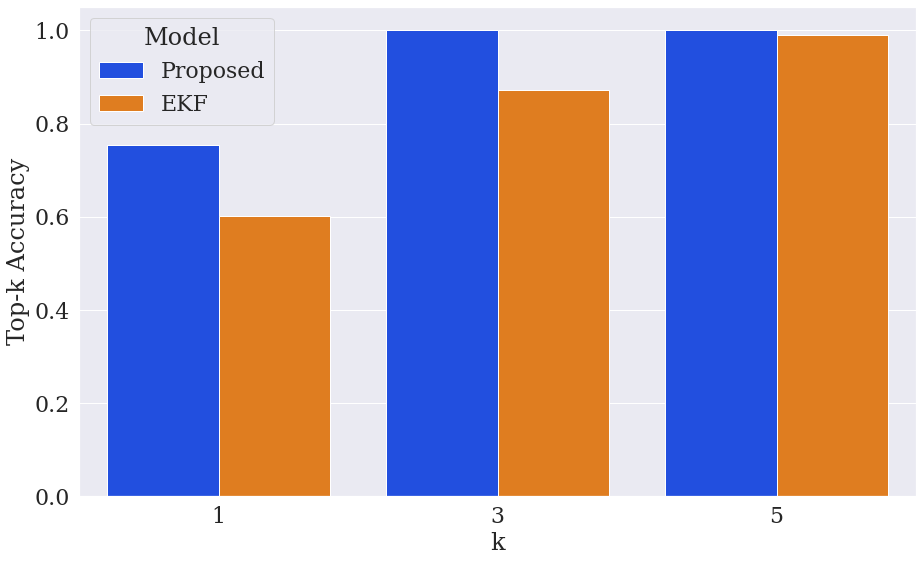

In [50]:
sns.set(font_scale = 2)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman Bold'})
fig, axes = plt.subplots(1, 1, figsize=(15, 9))
sample_df = pd.DataFrame({"k" : [1, 3, 5] + [1, 3, 5], "Top-k Accuracy" : [0.754266, 1, 1] + [0.602, 0.873, 0.991], "Model" : ["Proposed"] * 3 + ["EKF"] * 3})
sns.barplot(
    data=sample_df,
    x="k", y="Top-k Accuracy", hue="Model",
    ci="sd", palette="bright",
    ax=axes
)
plt.savefig('plots/intent_top_k.eps', format='eps')
#axes.set_title("Intent Predict")